# MorphOMICs demonstration

Change the directory to where `Morphomics` is located

In [1]:
# Only doing this for code development
# If `MorphOMICs` is installed in your system, comment this out
import os
os.chdir('/home/rcubero/Git_codes/MorphOMICs')

Load all the necessary libraries

In [2]:
import morphomics

import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [3]:
# let's define here the dictionaries that we will need along the way
parameters = {}
sample_data = {}

## Loading dataset

`Morphomics` takes an input 3D reconstructions of microglia in .swc format. Note that in the `data` folder, the file structure is <br>
├─ reconstructions  <br>
│&emsp;└─ brain region <br>
│&emsp;&emsp;&emsp;└─ condition <br>
│&emsp;&emsp;&emsp;&emsp;&emsp;└─ sex <br>
│&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;└─ mouse <br>

In [4]:
from morphomics.io import io

In [5]:
%%time

# The example data only has reconstructions from healthy, adult frontal cortex (FC) and hippocampus (DG)
brain_label = ['FC', 'DG']
conditions = ['Control']

# iterate over the brain region
for region in brain_label:
    sample_data[region] = {}

    # iterate over the conditions
    for cond in conditions:
        sample_data[region][cond] = {}

        # iterate over sex
        for sex in ['M', 'F']:
            # prompt user which samples are being processed
            print('Processing barcodes for %s_mg, %s (%s)...'%(region, cond, sex))

            input_directory = 'demo/data/reconstructions/%s/%s/%s/*/'%(region, cond, sex)
            sample_data[region][cond][sex] = {}
            sample_data[region][cond][sex] = io.get_clean_input(input_directory, extension="corrected.swc")

        # combine male and female barcodes
        keys_to_combine = ["barcodes"]
        list_of_data = [sample_data[region][cond]['M'], sample_data[region][cond]['F']]

        sample_data[region][cond]['Union'] = {}
        sample_data[region][cond]['Union'] = io.combine_data(list_of_data, keys_to_combine)

    # save the sample data (per brain region)
    morphomics.utils.save_obj(sample_data[region], 'demo/data/barcodes/SampleData_%s'%(region))

Processing barcodes for FC_mg, Control (M)...
Processing barcodes for FC_mg, Control (F)...
Processing barcodes for DG_mg, Control (M)...
Processing barcodes for DG_mg, Control (F)...
CPU times: user 1.43 s, sys: 15.1 ms, total: 1.44 s
Wall time: 1.46 s


## Bootstrapping and visualization

Here, we will use `Morphomics` to visualize brain-region dependent heterogeneity.

First, we need to set all the bootstrapping parameters

In [6]:
parameters['boostrapping'] = {}
parameters['boostrapping']['rand_seed'] = 34151  # random number seed, for reproducibility
parameters['boostrapping']['N_pop']     = 30     # bootstrap population size
parameters['boostrapping']['N_samples'] = 500    # number of bootstrap samples to generate

morphomics.utils.save_obj(parameters['boostrapping'], 'demo/parameters/bootstrap_parameters')

Instead of using the converted reconstructions above, we will turn to a richer dataset containing all the reconstructed microglia from healthy, adult mice.

In [7]:
%%time

# Here, the complete control dataset contains barcodes from brain regions covered in Colombo, Cubero et. al. (2022) 
# It is also contains male only, female only, and combined (male and female) dataset
brain_label = ['CB', 'CN', 'FC', 'DG', 'OB', 'S1', 'SN']
conditions = ['Control']

# Load the complete control dataset
complete_data = {}
for region in brain_label:
    complete_data[region] = morphomics.utils.load_obj('demo/data/barcodes/CompleteData_Adult_%s'%(region))
    
    # print out the number of reconstructions per brain region
    for cond in conditions:
        _lens = [len(complete_data[region][cond][sex]['barcodes']) for sex in ['Union', 'M', 'F']]
        print(region, '%5d, %5d, %5d'%(_lens[0], _lens[1], _lens[2]))

CB   545,   246,   299
CN   754,   256,   498
FC  1820,   894,   926
DG  1815,   913,   902
OB  1497,   701,   796
S1  1540,   821,   719
SN  2026,   976,  1050
CPU times: user 1.59 s, sys: 76.1 ms, total: 1.66 s
Wall time: 1.66 s


In [8]:
%%time

from morphomics.Analysis.bootstrapping import get_subsampled_population

# Here, we will bootstrap over the combined male and female dataset
# We will save the bootstrapped barcodes in complete_data
for region in brain_label:
    _bars, _inds = get_subsampled_population(complete_data[region][cond]['Union'],  
                                             parameters['boostrapping']['N_pop'], 
                                             parameters['boostrapping']['N_samples'], 
                                             parameters['boostrapping']['rand_seed'])
    complete_data[region][cond]['Union']['bootstrap_barcodes'] = _bars
    complete_data[region][cond]['Union']['bootstrap_index']    = _inds

    morphomics.utils.save_obj(complete_data[region], 'demo/output/bootstrapped_samples/CompleteData_Adult_%s'%(region))

CPU times: user 10.3 s, sys: 338 ms, total: 10.7 s
Wall time: 10.9 s


In [9]:
# define the persistence image parameters
parameters['image_parameters'] = {}
parameters['image_parameters']["xlims"]       = [0, 200]  # in microns, the range of birth distances from the soma to be considered
parameters['image_parameters']["ylims"]       = [0, 200]  # in microns, the range of death distances from the soma to be considered
parameters['image_parameters']["norm_method"] = "sum"     # how the persistence image will be normalized
parameters['image_parameters']["metric"]      = "l1"      # distance metric; TMD distances is l1
parameters['image_parameters']["chunks"]      = 10        # number of chunks for parallelization
parameters['image_parameters']['cutoff']      = 5         # minimum number of barcodes to consider

morphomics.utils.save_obj(parameters['image_parameters'], 'demo/parameters/image_parameters')

In [10]:
# define the UMAP parameters
parameters['UMAP'] = {}
parameters['UMAP']['N_dims']       = 10     # number of principal components to use for UMAP
parameters['UMAP']['n_neighbors']  = 50     # controls how UMAP balances local versus global structure in the data
parameters['UMAP']['min_dist']     = 1.0    # controls how tightly UMAP is allowed to pack points together
parameters['UMAP']['spread']       = 3.0    # controls the effective scale at which embedded points will be spread out
parameters['UMAP']['random_state'] = 35     # random number seed for UMAP

morphomics.utils.save_obj(parameters['UMAP'], 'demo/parameters/UMAP_parameters')

In [11]:
%%time

from morphomics.Analysis.reduction import calculate_umap

bootstrapped_barcodes = []
bootstrapped_labels = {}
for region in brain_label:
    init_len = len(bootstrapped_barcodes)
    bootstrapped_barcodes = bootstrapped_barcodes + complete_data[region]['Control']['Union']['bootstrap_barcodes']
    bootstrapped_labels[region] = np.arange(init_len, len(bootstrapped_barcodes))

X_umap = calculate_umap(bootstrapped_barcodes,
                        image_parameters=parameters['image_parameters'],
                        UMAP_parameters=parameters['UMAP'],
                        save_folder='demo/output/reduction',
                        save_prefix='Control')

Calculating distance matrix...
Calculating singular value decomposition...
Calculating UMAP representation...
Saving results...
Done!
CPU times: user 2min 30s, sys: 16.6 s, total: 2min 47s
Wall time: 3min 13s


In [12]:
parameters['colors'] = {}

# define the colors for plotting the UMAP
parameters['colors']['Control'] = {'CB': 'lightcoral',
                                   'CN': 'peru',
                                   'FC': 'darkorange',
                                   'DG': 'gold',
                                   'OB': 'forestgreen',
                                   'S1': 'dodgerblue',
                                   'SN': 'darkorchid' }

morphomics.utils.save_obj(parameters['colors'], 'demo/parameters/color_dictionary')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


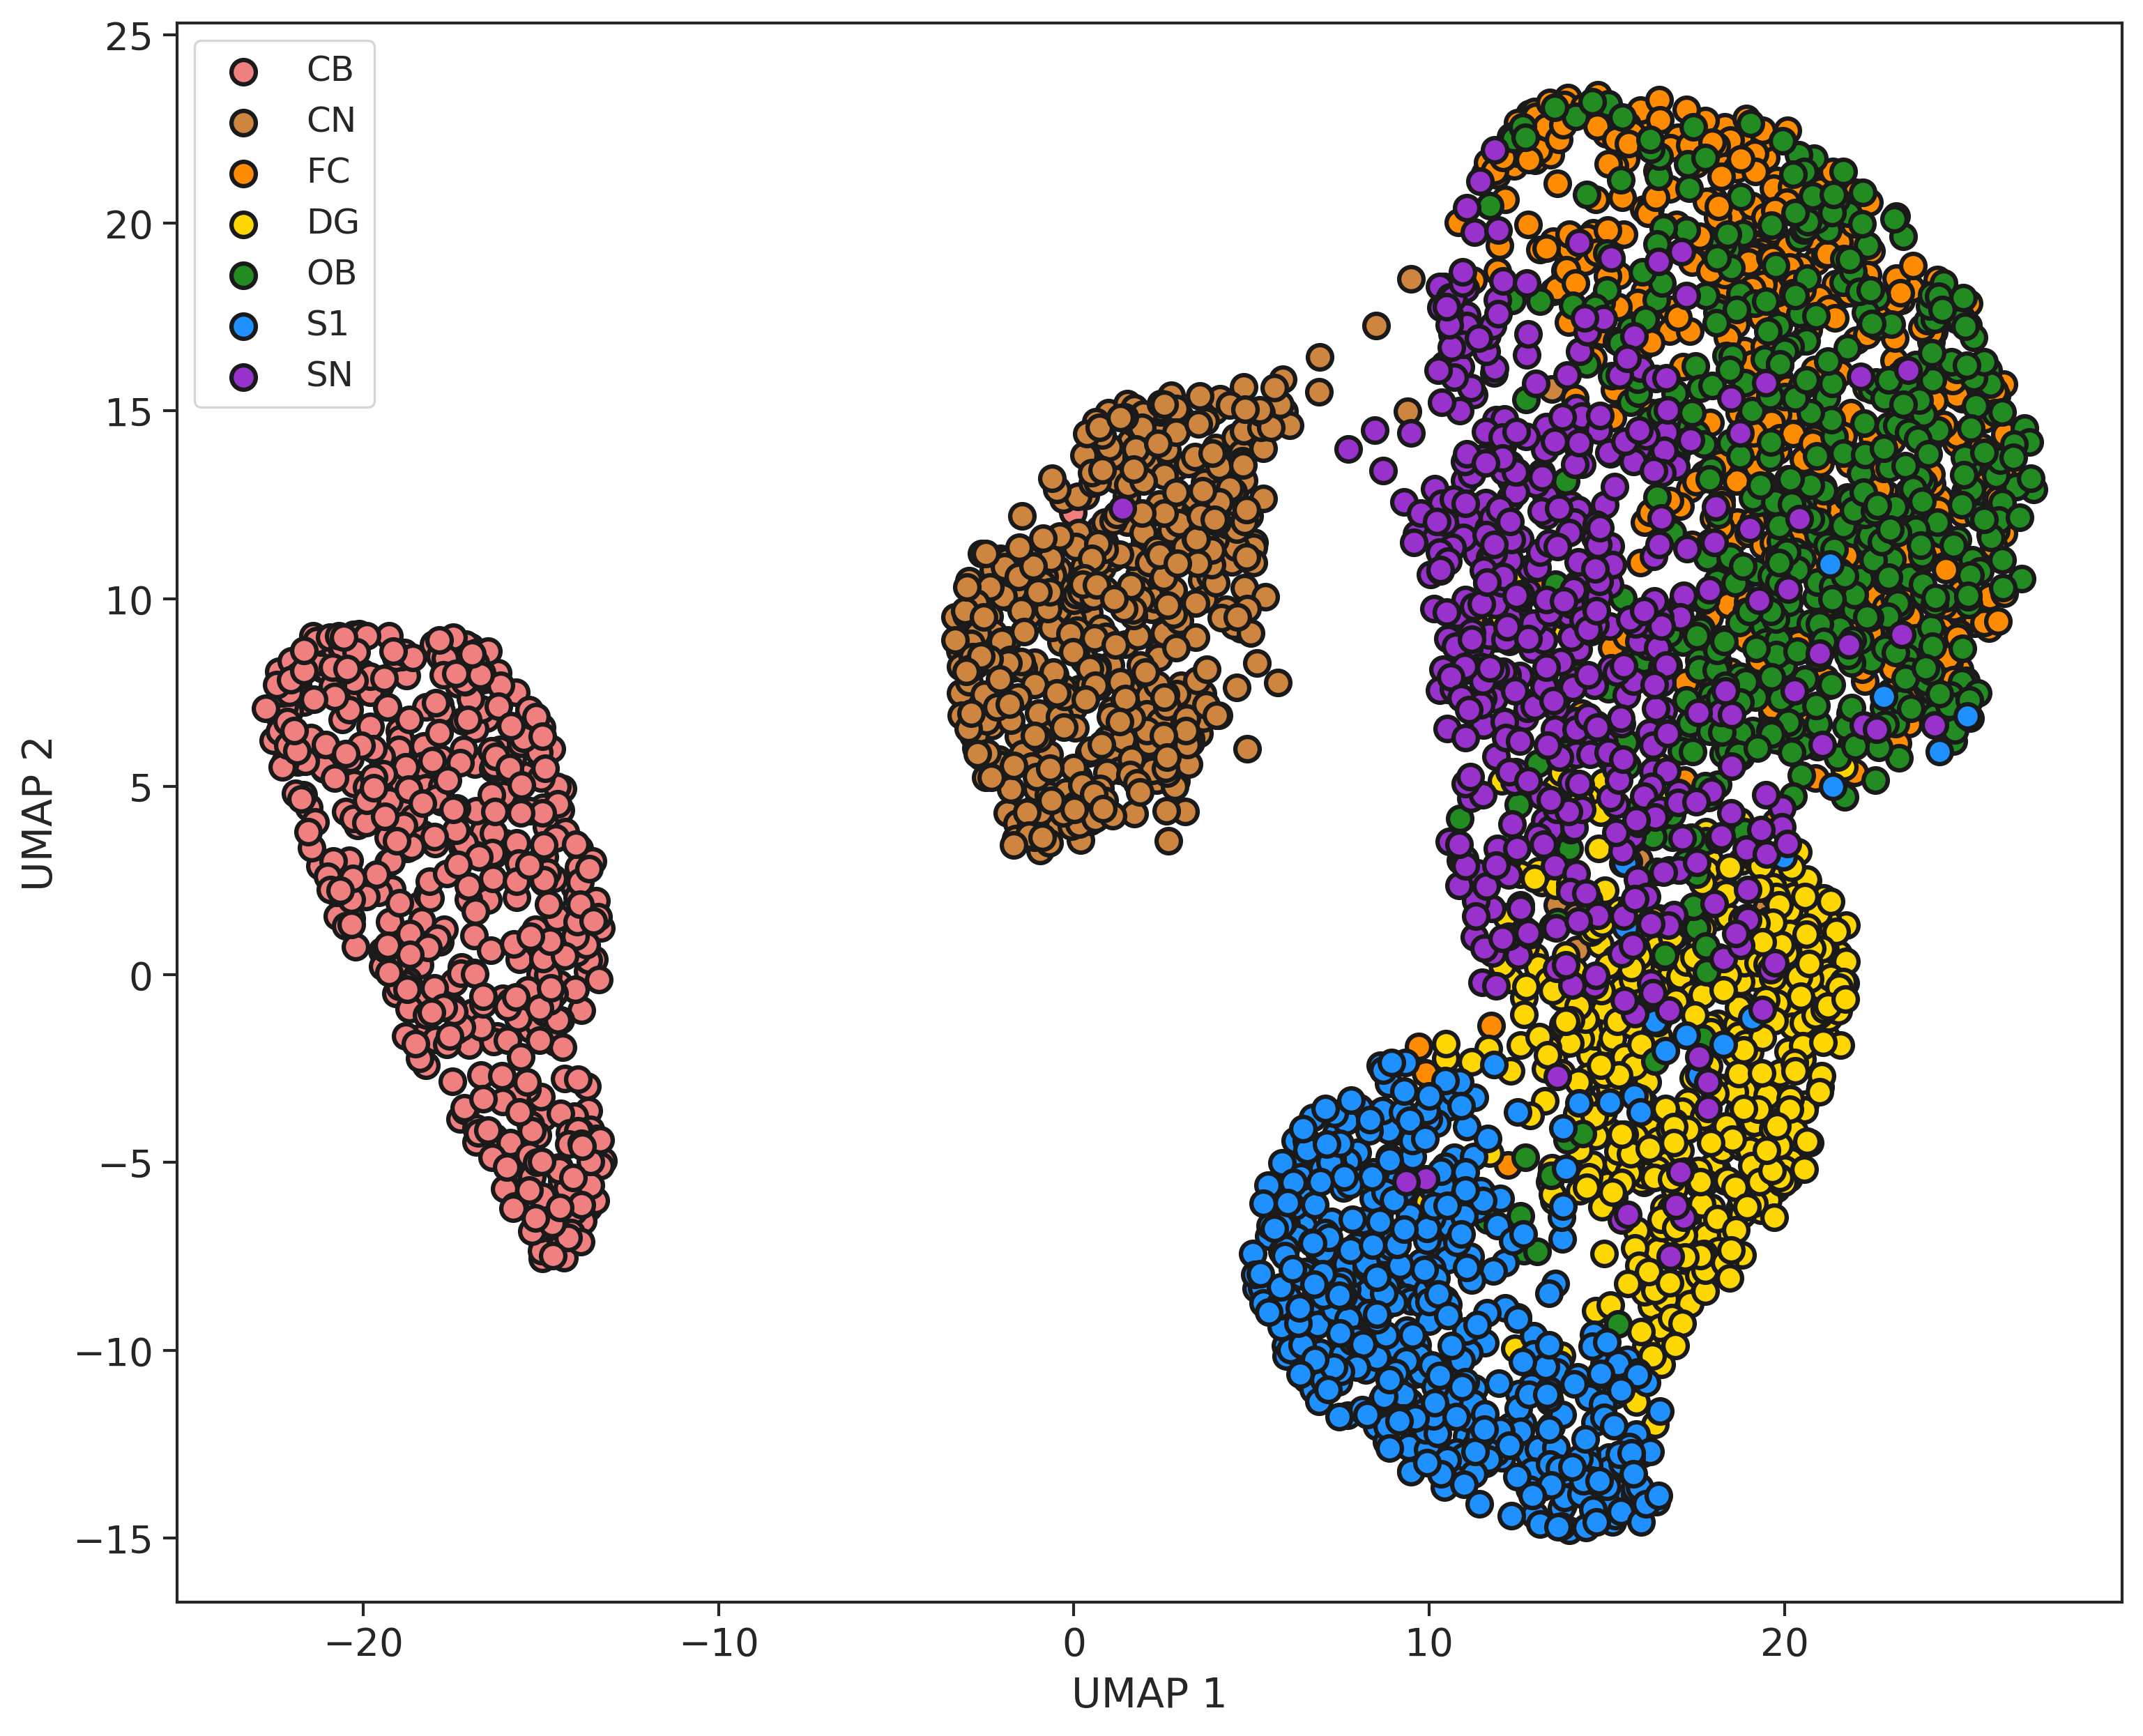

In [13]:
br_colors = { 'CB': 'lightcoral',
              'CN': 'peru',
              'FC': 'darkorange',
              'DG': 'gold',
              'OB': 'forestgreen',
              'S1': 'dodgerblue',
              'SN': 'darkorchid' }

# Visualize UMAP representation
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(12,10)

for region in brain_label:
    inds = bootstrapped_labels[region]
    ax.scatter(X_umap[:,0][inds], X_umap[:,1][inds], s=70, c=parameters['colors']['Control'][region], 
               marker='o', edgecolor='k', lw=1.5, label=region, rasterized=True)
    
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend(loc='upper left', fontsize=12)

plt.show()